In [63]:
# Based on  tutorial https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_regression_powerplant_output.ipynb
# Try to rerun model 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
#h2o.shutdown(prompt=True) 

[WARNING] in <ipython-input-3-b136f5fa3fcd> line 1:
    >>> h2o.shutdown(prompt=True)
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
Are you sure you want to shutdown the H2O instance running at http://localhost:54323 (Y/N)? Y
H2O session _sid_8ccd closed.


In [16]:
# Needed to install Java JRE https://www.java.com/en/download/win10.jsp 
import h2o 
from h2o.automl import H2OAutoML
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 . connected.


H2O cluster uptime:,5 mins 53 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_dmmma_htld0z
H2O cluster total nodes:,1
H2O cluster free memory:,707 kb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


### Load data

In [87]:
%ls

 Volume in drive C is Local Disk
 Volume Serial Number is AA1B-997A

 Directory of C:\Users\dmmma\Documents\GDSO\gdso_2019\notebooks\exploring_models

16-Aug-19  11:16 AM    <DIR>          .
16-Aug-19  11:16 AM    <DIR>          ..
09-Aug-19  12:24 AM                 2 .gitkeep
16-Aug-19  10:56 AM    <DIR>          .ipynb_checkpoints
15-Aug-19  08:54 PM            49,015 2019-07-05-autoML.ipynb
15-Aug-19  10:10 PM           685,083 2019-07-14-notes_for_running_RF_on_cluster.ipynb
15-Aug-19  05:46 PM           686,439 2019-07-14-update_RF.ipynb
15-Aug-19  09:31 PM            40,857 2019-07-15-autoML-GLM.ipynb
16-Aug-19  11:16 AM           280,581 2019-07-15-plots-w-large-dataset.ipynb
09-Aug-19  12:24 AM           114,298 LSTM.ipynb
15-Aug-19  10:42 PM       307,468,699 test.csv
15-Aug-19  09:40 PM       233,041,711 test_light.csv
16-Aug-19  11:16 AM     1,211,249,073 train.csv
15-Aug-19  09:41 PM       917,846,895 train_light.csv
09-Aug-19  12:45 AM        40,128,063 weather1_education

In [ ]:
# test.csv has temperature, test_light does not

#train_raw = pd.read_csv('train_light.csv')
#val_raw = pd.read_csv('test_light.csv')

val_raw = pd.read_csv('test.csv')
#train_raw = pd.read_csv('train.csv') - too big to load

In [65]:
val_raw.head()

,Unnamed: 0,timestamp,electricity,building_name,weather_file,industry,area,primary_space_usage,TemperatureC,month,...,weather_file_weather8.csv,weather_file_weather9.csv,industry_Commercial Property,industry_Education,industry_Government,primary_space_usage_Office,primary_space_usage_PrimClass,primary_space_usage_UnivClass,primary_space_usage_UnivDorm,primary_space_usage_UnivLab
0,24,2015-01-01 07:00:00,5.33,Office_Abigail,weather0.csv,Education,901.437809,Office,2.8,1,...,0,0,0,1,0,1,0,0,0,0
1,120,2015-01-01 08:00:00,5.41,Office_Abigail,weather0.csv,Education,901.437809,Office,2.8,1,...,0,0,0,1,0,1,0,0,0,0
2,216,2015-01-01 09:00:00,5.60,Office_Abigail,weather0.csv,Education,901.437809,Office,3.9,1,...,0,0,0,1,0,1,0,0,0,0
3,312,2015-01-01 10:00:00,6.50,Office_Abigail,weather0.csv,Education,901.437809,Office,5.0,1,...,0,0,0,1,0,1,0,0,0,0
4,408,2015-01-01 11:00:00,5.39,Office_Abigail,weather0.csv,Education,901.437809,Office,5.6,1,...,0,0,0,1,0,1,0,0,0,0


In [66]:
val_raw.columns

Index(['Unnamed: 0', 'timestamp', 'electricity', 'building_name',
       'weather_file', 'industry', 'area', 'primary_space_usage',
       'TemperatureC', 'month',
       ...
       'weather_file_weather8.csv', 'weather_file_weather9.csv',
       'industry_Commercial Property', 'industry_Education',
       'industry_Government', 'primary_space_usage_Office',
       'primary_space_usage_PrimClass', 'primary_space_usage_UnivClass',
       'primary_space_usage_UnivDorm', 'primary_space_usage_UnivLab'],
      dtype='object', length=133)

In [67]:
val_raw['primary_space_usage'].unique()

array(['Office', 'PrimClass', 'UnivClass', 'UnivDorm', 'UnivLab'],
      dtype=object)

In [68]:
train_data = train_raw.drop(['Unnamed: 0', 'timestamp','building_name', 'weather_file', 'industry'], axis=1)
val_data = val_raw.drop(['Unnamed: 0', 'timestamp','building_name', 'weather_file', 'industry'], axis=1)

train_data.head()


,electricity,area,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,weather_file_weather8.csv,weather_file_weather9.csv,industry_Commercial Property,industry_Education,industry_Government,primary_space_usage_Office,primary_space_usage_PrimClass,primary_space_usage_UnivClass,primary_space_usage_UnivDorm,primary_space_usage_UnivLab
0,27.79,6891.54454,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,27.66,6891.54454,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,27.13,6891.54454,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,27.34,6891.54454,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,27.34,6891.54454,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [15]:
train_data.shape

(3455090, 91)

In [17]:
val_data.shape

(877653, 91)

#### Ranges of all variables

In [58]:
val_raw.describe()

,Unnamed: 0,electricity,area,TemperatureC,month,date,hour,weekday,month_1,month_2,...,weather_file_weather8.csv,weather_file_weather9.csv,industry_Commercial Property,industry_Education,industry_Government,primary_space_usage_Office,primary_space_usage_PrimClass,primary_space_usage_UnivClass,primary_space_usage_UnivDorm,primary_space_usage_UnivLab
count,8.776530e+05,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,...,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000,877653.000000
mean,2.230706e+06,141.972499,9527.873554,6.487953,6.526017,15.722847,11.550233,2.998055,0.084182,0.076583,...,0.029923,0.008755,0.019209,0.911049,0.069742,0.321280,0.168515,0.124170,0.207687,0.178348
std,1.233098e+06,293.361549,16127.370067,261.507865,3.439655,8.782150,6.877534,1.999646,0.277661,0.265928,...,0.170375,0.093159,0.137260,0.284673,0.254711,0.466968,0.374324,0.329775,0.405652,0.382806
min,0.000000e+00,0.006897,399.297094,-9999.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.155717e+06,15.703425,2800.375129,6.600000,4.000000,8.000000,6.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.297005e+06,59.599998,6033.200000,13.300000,7.000000,16.000000,12.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.348139e+06,156.600000,11389.164580,20.600000,10.000000,23.000000,17.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,4.332778e+06,3150.060000,155679.415200,80.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Exploring temperature

In [57]:
val_raw['TemperatureC'].describe()

count    877653.000000
mean          6.487953
std         261.507865
min       -9999.000000
25%           6.600000
50%          13.300000
75%          20.600000
max          80.000000
Name: TemperatureC, dtype: float64

Text(0, 0.5, 'Occurance')

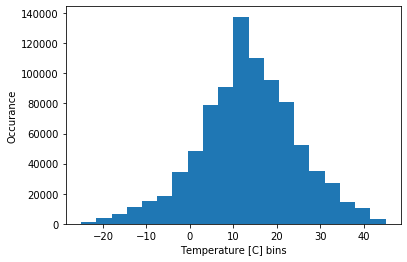

In [75]:
# Try a plot - filter to remove missing vals
plt.hist(x = 'TemperatureC', bins = 20, range = (-25,45), data = val_raw );
plt.xlabel("Temperature [C] bins");
plt.ylabel("Occurance");
plt.title("Distribution of temperature in val data")

Text(0.5, 1.0, 'All buildings in val data')

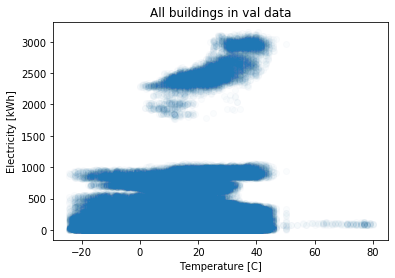

In [81]:
# All buildings
plt.scatter(x = 'TemperatureC', y = 'electricity', data = val_raw[val_raw['TemperatureC']> -25], alpha = 0.02);
plt.show
plt.xlabel("Temperature [C]");
plt.ylabel("Electricity [kWh]");
plt.title("All buildings in val data")

Text(0.5, 1.0, 'Offices, Dorms, Primary and Uni Classrooms in val data')

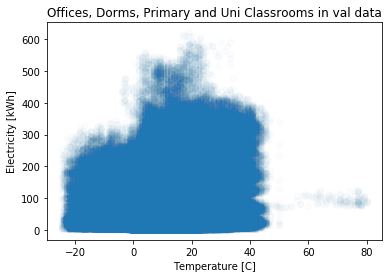

In [82]:
# Everything but the UnivLabs

plt.scatter(x = 'TemperatureC', y = 'electricity', data = val_raw[(val_raw.TemperatureC >= -25) & (val_raw.primary_space_usage != 'UnivLab')], alpha = 0.02);
plt.show
plt.xlabel("Temperature [C]");
plt.ylabel("Electricity [kWh]");
plt.title("Offices, Dorms, Primary and Uni Classrooms in val data")

Text(0.5, 1.0, 'UnivLabs in val data')

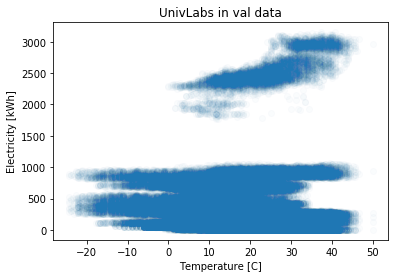

In [83]:
# Just labs

plt.scatter(x = 'TemperatureC', y = 'electricity', data = val_raw[(val_raw.TemperatureC >= -25) & (val_raw.primary_space_usage == 'UnivLab')], alpha = 0.02);
plt.show;
plt.xlabel("Temperature [C]");
plt.ylabel("Electricity [kWh]");
plt.title("UnivLabs in val data")

<function matplotlib.pyplot.show(*args, **kw)>

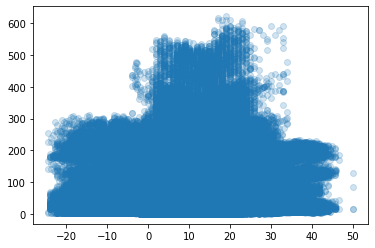

In [73]:
# Just Offices

plt.scatter(x = 'TemperatureC', y = 'electricity', data = val_raw[(val_raw.TemperatureC >= -25) & (val_raw.primary_space_usage == 'Office')], alpha = 0.2);
plt.show
plt.xlabel("Temperature [C]");
plt.ylabel("Electricity [kWh]");
plt.title("Offices in val data")

In [84]:
#### Exploring area

<function matplotlib.pyplot.show(*args, **kw)>

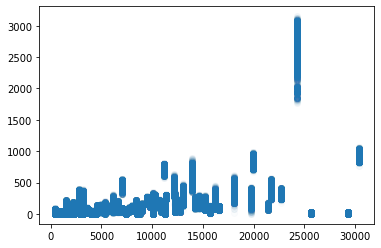

In [85]:
# Area

# Filtering out what appears to be one extremely large building for 
plt.scatter(x = 'area', y = 'electricity', data = val_raw[val_raw.area <= 60000], alpha = 0.02);
plt.show
plt.xlabel("area [m^2] ");
plt.ylabel("Electricity [kWh]");
plt.title("All buildings in val data")

In [28]:
val_raw.columns

Index(['Unnamed: 0', 'timestamp', 'electricity', 'building_name',
       'weather_file', 'industry', 'area', 'primary_space_usage',
       'TemperatureC', 'month',
       ...
       'weather_file_weather8.csv', 'weather_file_weather9.csv',
       'industry_Commercial Property', 'industry_Education',
       'industry_Government', 'primary_space_usage_Office',
       'primary_space_usage_PrimClass', 'primary_space_usage_UnivClass',
       'primary_space_usage_UnivDorm', 'primary_space_usage_UnivLab'],
      dtype='object', length=133)

In [12]:
train_data_smaller = train_data.head(876000)

In [13]:
val_data_smaller = val_data.head(8760*30)

### Try to load into h2o dataframe - memory error

In [15]:
# Using one train/val split, not walk-forward cross-val
# In h2o, if using all other cols for x, don't have to explicitly specify
# Takes > 1 min to run

# Must be formatted as h2o frames http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html
train =  h2o.H2OFrame(train_data_smaller)
test = h2o.H2OFrame(val_data_smaller)


H2OServerError: HTTP 500 Server Error:
'<html>\n<head>\n<meta http-equiv="Content-Type" content="text/html;charset=ISO-8859-1"/>\n<title>Error 500 Server Error</title>\n</head>\n<body>\n<h2>HTTP ERROR: 500</h2>\n<p>Problem accessing /3/PostFile. Reason:\n<pre>    Server Error</pre></p>\n\n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n                                                \n</body>\n</html>\n'